## DQN

In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
!pip install tensorflow-gpu

In [ ]:
import numpy as np
from scipy.special import softmax
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [ ]:
#@title
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F

class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
#@title
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
#@title
class TutorialAgent():

    def __init__(self, state_size, action_size, fc1, fc2, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, UPDATE_EVERY, lim, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.lim = lim

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, fc1_units = fc1, fc2_units = fc2, seed = seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, fc1_units = fc1, fc2_units = fc2, seed = seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, self.GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-self.lim, self.lim)
            
        self.optimizer.step()

In [ ]:
#@title
''' Defining DQN Algorithm '''

def dqn(agent, n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                 
    ''' list containing scores from each episode '''
    steps = []

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start                    
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        st = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            st += 1
            if done:
                break 

        scores.append(score)       
        steps.append(st)   
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        # if i_episode % 10 == 0: 
        #     scores.append(np.mean(scores_window_printing))        
        # if i_episode % 100 == 0: 
        #    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=195.0:
        #    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        #    break
    return [scores, steps]

In [ ]:
#@title
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env
  
def simulate_episode_dqn(env, wrap = False, render = False, video = False, log = False): #if
 if(wrap):
   env = wrap_env(env)
 obs = env.reset()
 cumulative_reward = 0
 while True:
 #Rendering function
  if(render):
    env.render()
#take an action, take a step and continue the episode if the next state is not termin
  action = agent.act(obs)
  obs, reward, done, _ = env.step(action)
  if done:
    break
  cumulative_reward += reward
  if log:
    if not cumulative_reward%50 and not done:
      print('Step reward: ', reward)
      print('Cumulative reward: ', cumulative_reward)
 env.close()
 if(video):
  show_video()
 return cumulative_reward

## CartPole-v1

In [ ]:
env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")

4
2
1
----
[-0.04456399  0.04653909  0.01326909 -0.02099827]
----
1
----
[-0.04363321  0.24146826  0.01284913 -0.30946528]
1.0
False
{}
----


## Variation 1

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.99            
LR = 5e-4               
UPDATE_EVERY = 20 
EPISODES = 1000
LIM = 1
FC1 = 128
FC2 = 64

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

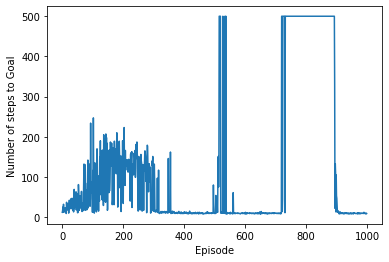

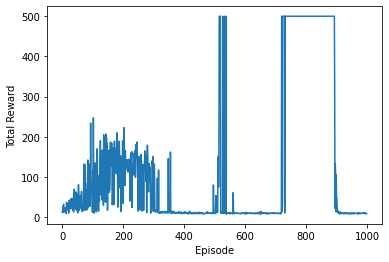

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
idx = -1
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list.append(temp)
  if idx == -1 and temp > 475:
    idx = i  

Episodes taken to solve the environment:  818


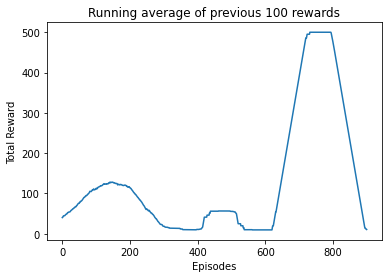

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Episodes taken to solve the environment: ', idx + 100)

In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  121699.48500000002


## Variation 2

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64    
GAMMA = 0.95
LR = 5e-5               
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 0.7
FC1 = 128
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

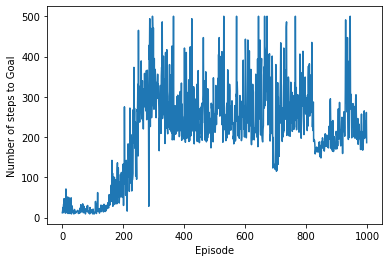

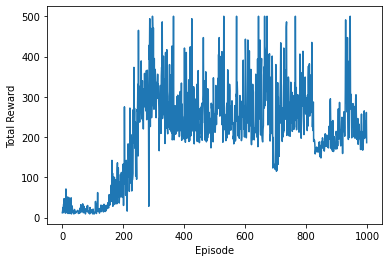

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
idx = -1
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list.append(temp)
  if idx == -1 and temp > 475:
    idx = i  

Episodes taken to solve the environment:  99


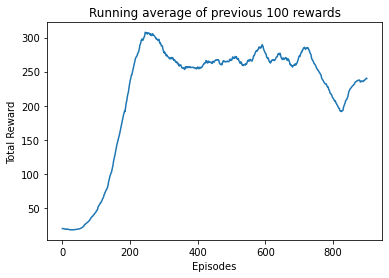

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Episodes taken to solve the environment: ', idx + 100)

In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  197394.805


## Variation 3

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 96    
GAMMA = 0.95
LR = 5e-5               
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 0.7
FC1 = 128
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

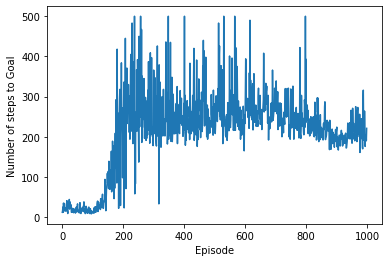

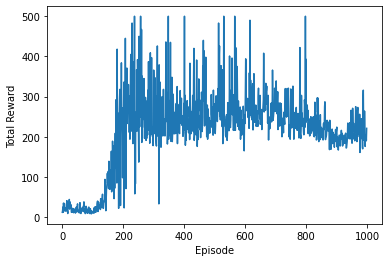

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
idx = -1
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list.append(temp)
  if idx == -1 and temp > 475:
    idx = i  

Episodes taken to solve the environment:  99


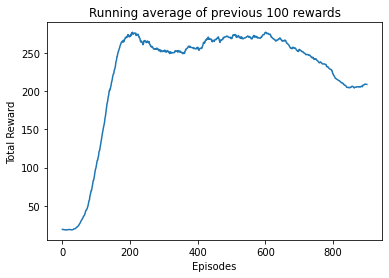

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Episodes taken to solve the environment: ', idx + 100)

In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  201565.0


## Variation 4

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 96    
GAMMA = 0.95
LR = 5e-5               
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 0.7
FC1 = 200
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

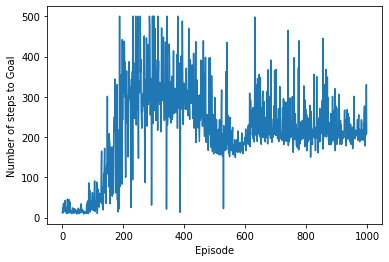

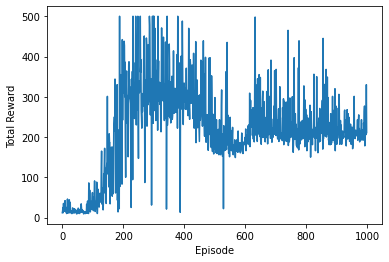

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
idx = -1
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list.append(temp)
  if idx == -1 and temp > 475:
    idx = i  

Episodes taken to solve the environment:  99


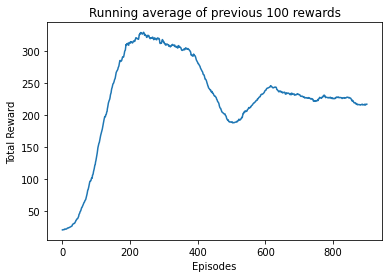

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Episodes taken to solve the environment: ', idx + 100)

In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  204873.025


## Variation 5

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 110  
GAMMA = 0.95
LR = 5e-5               
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 0.7
FC1 = 200
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

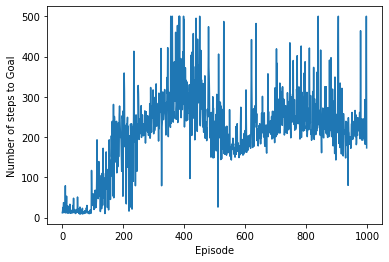

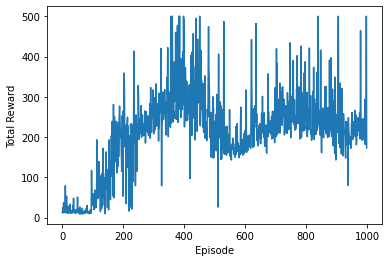

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
idx = -1
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list.append(temp)
  if idx == -1 and temp > 475:
    idx = i  

Episodes taken to solve the environment:  99


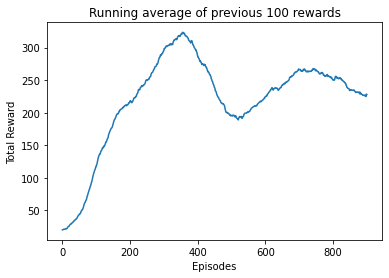

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Episodes taken to solve the environment: ', idx + 100)

In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  198089.61500000002


## Acrobot-v1

In [ ]:
env = gym.make('Acrobot-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")

6
3
2
----
[ 0.99603073 -0.08901003  0.99567135  0.09294385  0.02653819 -0.04199653]
----
0
----
[ 0.99829918 -0.05829878  0.99945086  0.03313578  0.27308215 -0.54190945]
-1.0
False
{}
----


## Variation 1

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.99            
LR = 5e-4               
UPDATE_EVERY = 20 
EPISODES = 1000
LIM = 1
FC1 = 128
FC2 = 64

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

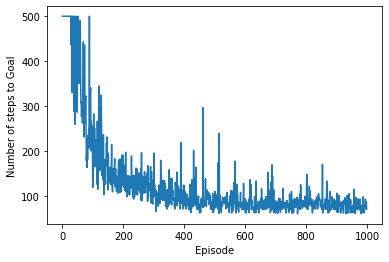

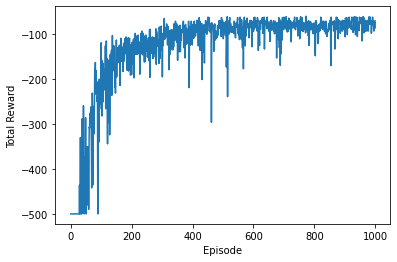

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -77.07


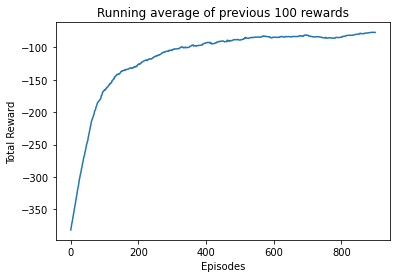

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -103064.02000000002


## Variation 2

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.99           
LR = 5e-4               
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 1
FC1 = 128
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

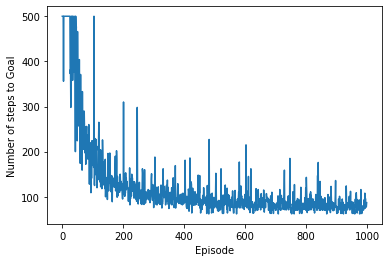

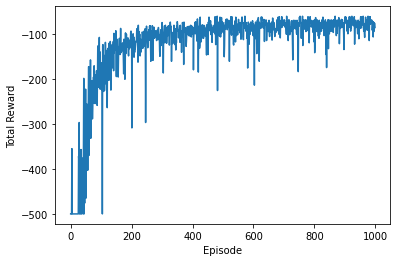

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -78.42


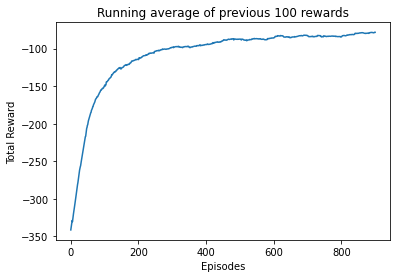

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -97394.57


## Variation 3

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 100         
GAMMA = 0.99           
LR = 5e-4               
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 1
FC1 = 128
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

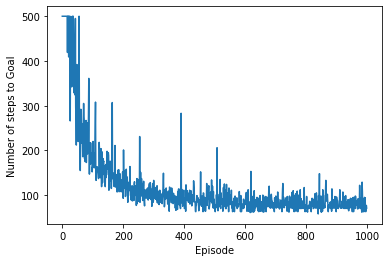

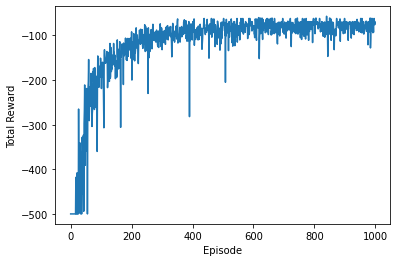

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -79.91


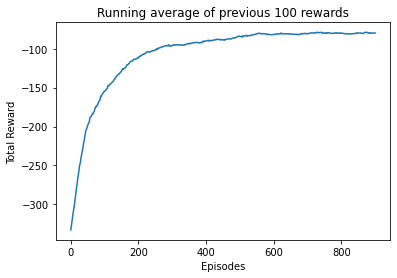

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -95281.095


## Variation 4

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 100         
GAMMA = 0.99           
LR = 5e-4               
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 1
FC1 = 256
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

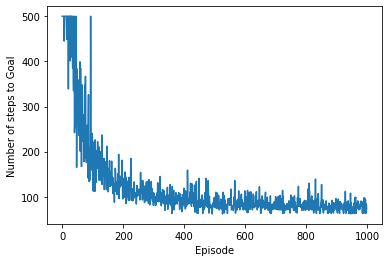

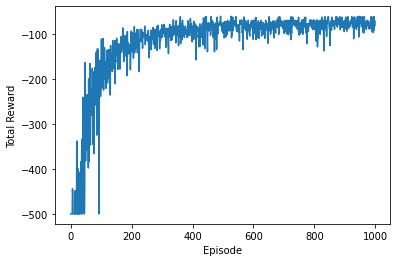

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -77.51


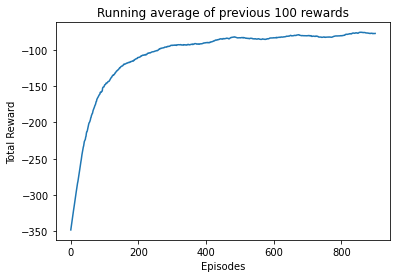

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -95378.13500000001


## Variation - 5

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 120
GAMMA = 0.99           
LR = 5e-4      
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 1.7
FC1 = 256
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

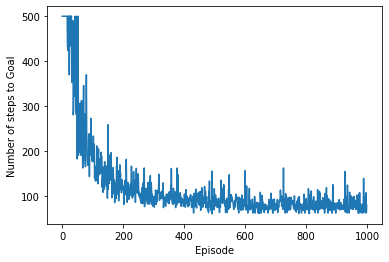

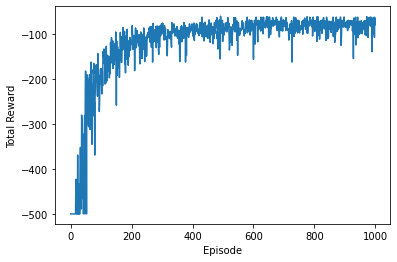

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -81.54


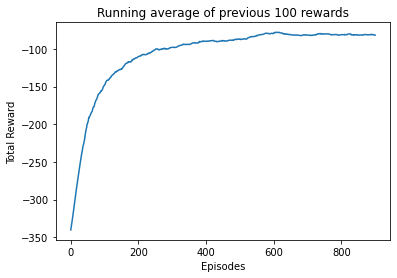

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -95216.11


## MountainCar-v0

In [ ]:
env = gym.make('MountainCar-v0')
env.seed(0)

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")

2
3
1
----
[-0.58912799  0.        ]
----
1
----
[-5.88639679e-01  4.88309600e-04]
-1.0
False
{}
----


## Variation 1

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.99            
LR = 5e-4               
UPDATE_EVERY = 20 
EPISODES = 1000
LIM = 1
FC1 = 128
FC2 = 64

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

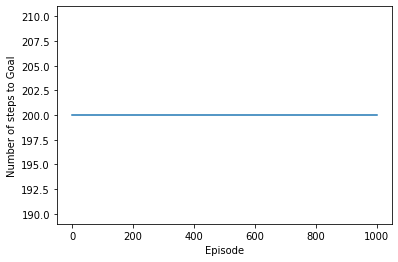

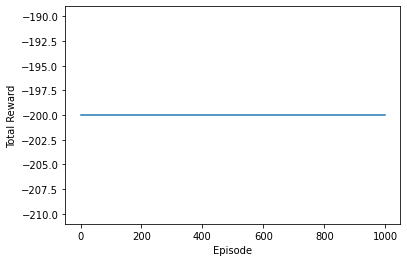

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -200.0


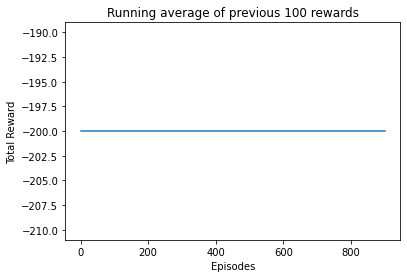

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

## Variation 2

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 32         
GAMMA = 0.80
LR = 2e-2       
UPDATE_EVERY = 1 
EPISODES = 1000
LIM = 1
FC1 = 256
FC2 = 256

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

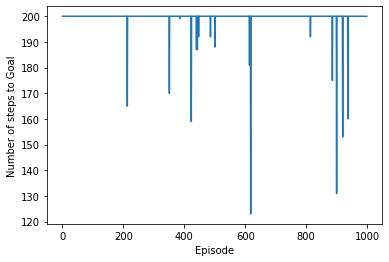

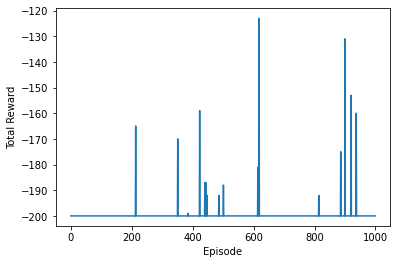

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -198.44


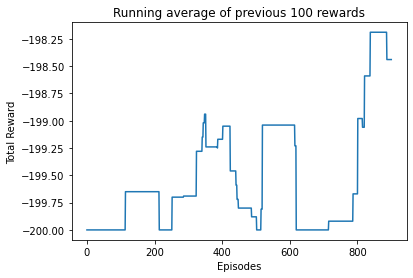

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -179578.98000000004


## Variation 3

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 32         
GAMMA = 0.2
LR = 2e-2       
UPDATE_EVERY = 1 
EPISODES = 1000
LIM = 1
FC1 = 256
FC2 = 256

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

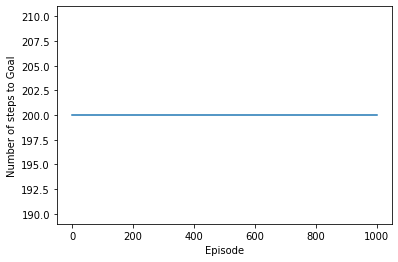

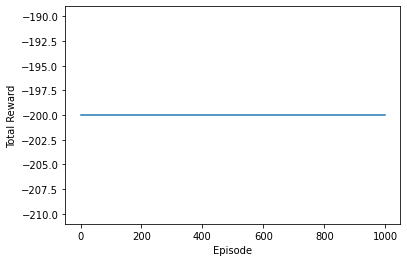

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -200.0


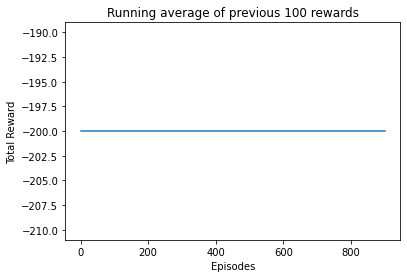

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -180000.0


## Variation 4

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 32         
GAMMA = 0.9
LR = 2e-3       
UPDATE_EVERY = 20 
EPISODES = 1000
LIM = 2
FC1 = 128
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

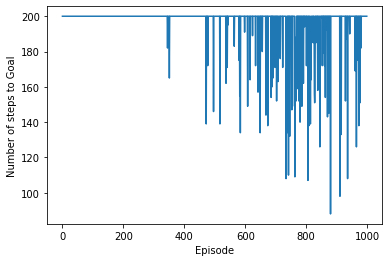

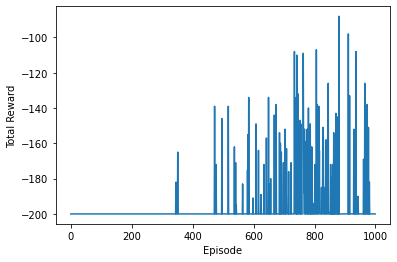

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -194.09


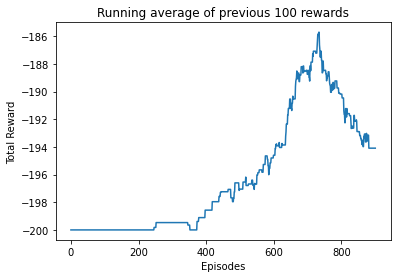

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -176531.745


## Variation 5

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.9
LR = 2e-3       
UPDATE_EVERY = 40 
EPISODES = 1000
LIM = 2
FC1 = 128
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

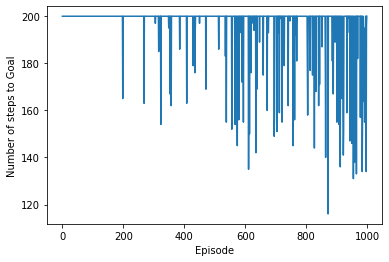

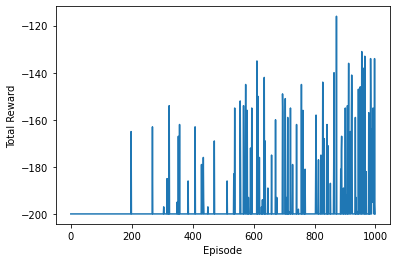

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -186.33


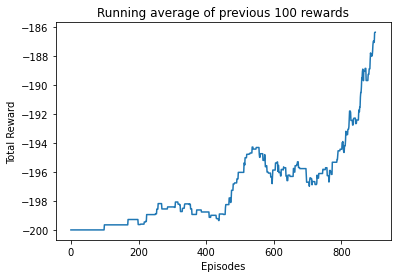

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -177314.635


## Variation 6

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.9
LR = 2e-3       
UPDATE_EVERY = 40 
EPISODES = 1000
LIM = 2
FC1 = 256
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

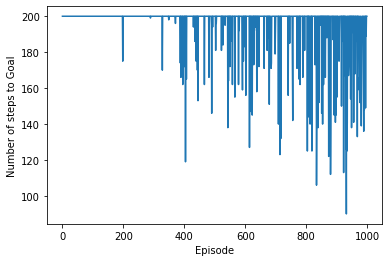

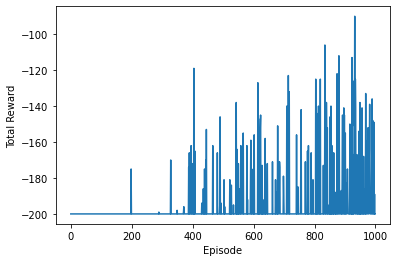

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -184.47


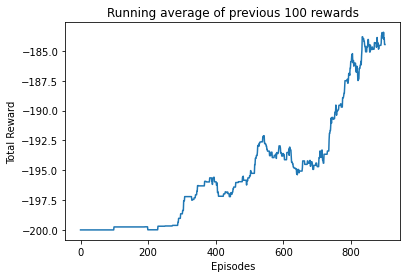

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -175640.935


## Variation 7

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.9
LR = 2e-4       
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 2
FC1 = 256
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

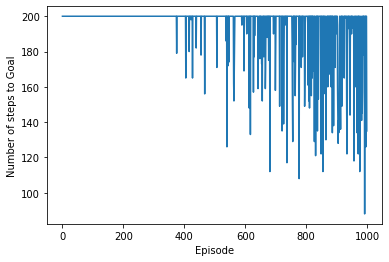

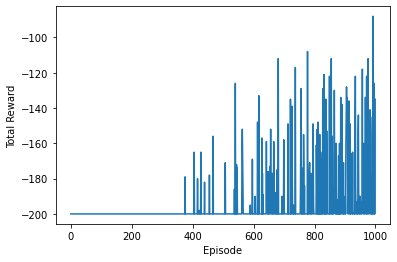

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -180.88


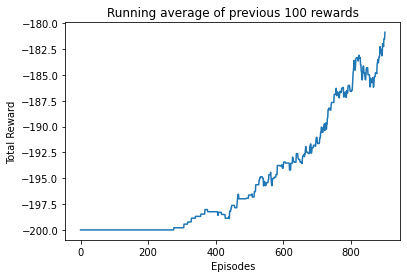

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -175689.19


## Variation 8

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.9
LR = 2e-4       
UPDATE_EVERY = 50 
EPISODES = 1500
LIM = 2
FC1 = 256
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES, eps_decay = 0.99)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

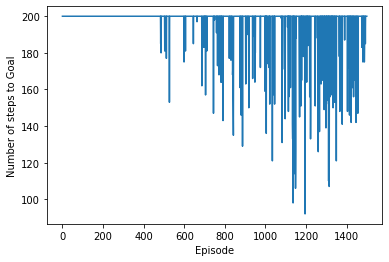

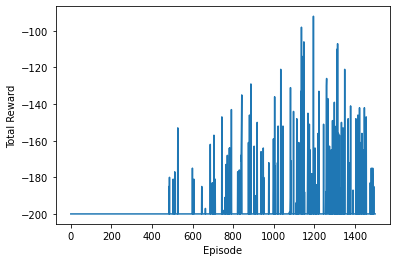

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -193.23


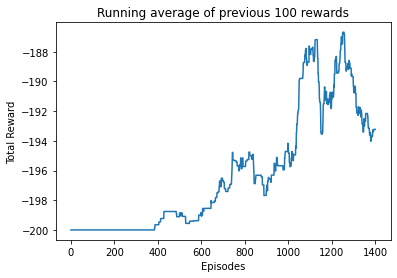

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -274747.04500000004


## Variation 9

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 96      
GAMMA = 0.9
LR = 2e-4       
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 2
FC1 = 256
FC2 = 128

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

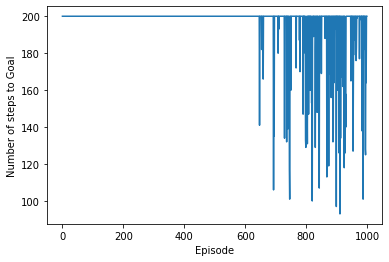

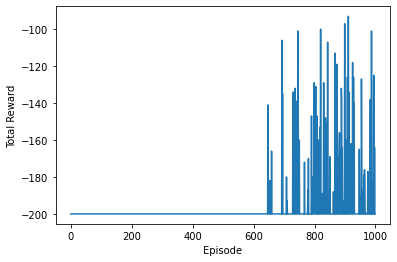

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -186.27


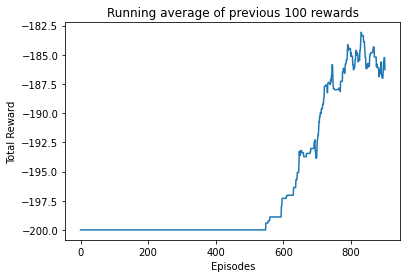

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -176709.20500000002


## Variation 10

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 96      
GAMMA = 0.9
LR = 2e-4       
UPDATE_EVERY = 50 
EPISODES = 1000
LIM = 2
FC1 = 256
FC2 = 256

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

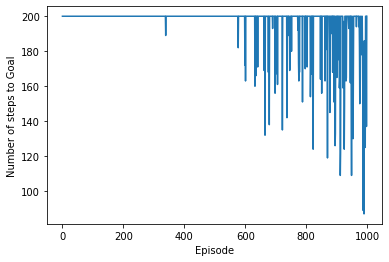

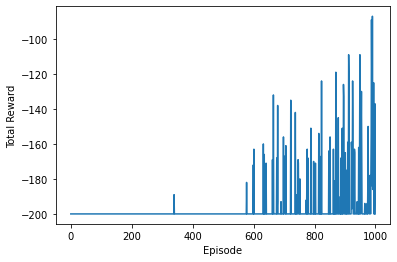

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -182.43


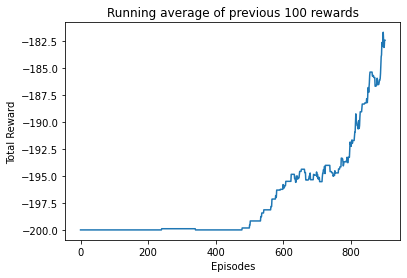

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -177469.275


## Variation 11

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 96      
GAMMA = 0.9
LR = 2e-4       
UPDATE_EVERY = 80 
EPISODES = 1000
LIM = 3
FC1 = 256
FC2 = 256

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

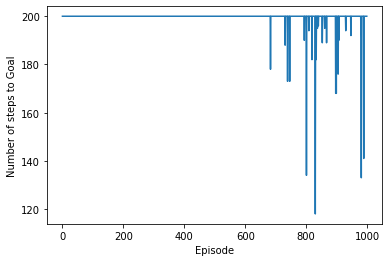

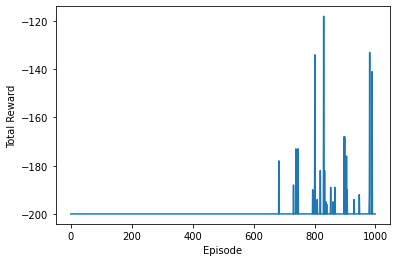

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -198.17


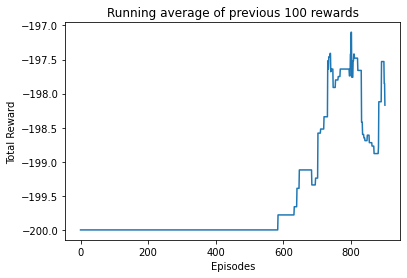

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
# Compute the area using the composite trapezoidal rule.
area = np.trapz(avg_reward_list)
print("Area under the curve: ", area)

Area under the curve:  -179551.35499999998


## Variation 12

In [ ]:
'''
Hyper parameters
'''
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.75            
LR = 1e-2               
UPDATE_EVERY = 10 
EPISODES = 1000
LIM = 1
FC1 = 128
FC2 = 64

In [ ]:
# Epsilon-greedy
scores = []
steps = []
for n in range(1):
  # begin_time = datetime.datetime.now()
  agent = TutorialAgent(state_size = state_shape, action_size = action_shape, fc1 = FC1, fc2 = FC2, BUFFER_SIZE = BUFFER_SIZE, 
                        BATCH_SIZE = BATCH_SIZE, GAMMA = GAMMA, LR = LR, UPDATE_EVERY = UPDATE_EVERY, lim = LIM, seed = 0)

  score, st = dqn(agent, n_episodes = EPISODES)

  # time_taken = datetime.datetime.now() - begin_time
  # print(time_taken)
  scores.append(score)
  steps.append(st)

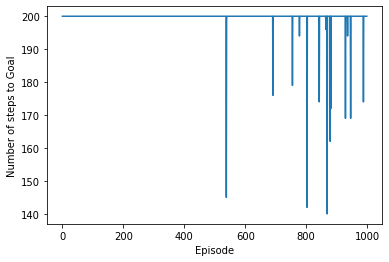

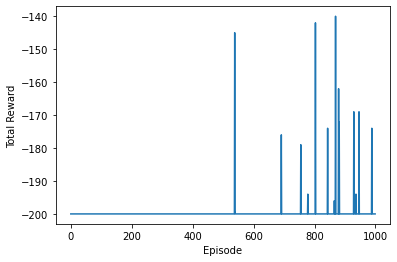

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(EPISODES), np.average(steps, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(EPISODES), np.average(scores, 0))
plt.show()

In [ ]:
avg_reward_list = []
reward_list = np.average(scores, 0)
for i in range(len(reward_list) - 99):
  avg_reward_list.append(np.mean(reward_list[i:i + 100])) 

Running average of previous 100 rewards:  -199.06


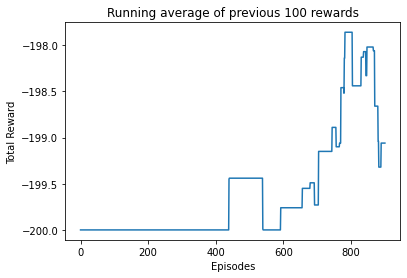

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')
print('Running average of previous 100 rewards: ', avg_reward_list[-1])

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = False)
print("Cumulative reward after episode termination", total_rew)

Cumulative reward after episode termination -199.0


In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
import math
from scipy.special import softmax

In [ ]:
import numpy as np
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.var(axis=-1)

## Actor-Critic

In [ ]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=1024, n_hidden2=512):
        super(ActorCriticModel, self).__init__()

        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

#### One-Step Return Agent
 

In [ ]:
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.99, seed = 85, n_hidden1=1024, n_hidden2=512):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size, n_hidden1=n_hidden1, n_hidden2=n_hidden2)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state, done):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)
            

            #### TO DO: Write the equation for delta (TD error)
            ## Write code below
            delta = reward+self.gamma*V_s_next-V_s

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

#### Full Returns Agent

In [ ]:
import math
class AgentFullReturn:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.99, seed = 85, n_hidden1=1024, n_hidden2=512):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr), run_eagerly = True)
        np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, actions, pis, deltas):
        """
        Compute Actor Loss
        """
        l = tf.convert_to_tensor(0.)
        actionsn = tf.convert_to_tensor(actions)
        for i in tf.range(tf.shape(actionsn)[0]):
          l = l -tf.math.log(pis[i][0][actions[i]]) * deltas[i] 
        
        # tf.math.multiply(pis, deltas)

        return l

    def critic_loss(self,deltas):
        """
        Critic loss aims to minimize TD error
        """
        return tf.math.reduce_sum(tf.math.square(deltas))

    @tf.function
    def learn(self, state_trajectories, actions, reward_count):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        deltas = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        pis = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        with tf.GradientTape(persistent=True) as tape:
          for i in tf.range(tf.shape(state_trajectories)[0]):
            delta = tf.convert_to_tensor(0.)
            state = state_trajectories[i]
            pi, V_s = self.ac_model(state)
            V_s = tf.squeeze(V_s)
            for j in tf.range(i,tf.shape(state_trajectories)[0]):
              delta = delta + tf.math.pow(self.gamma,tf.cast(j-i,tf.float32))*reward_count[j]
              
              #### TO DO: Write the equation for delta (TD error)
              ## Write code below
              
            delta = delta - V_s

            deltas = deltas.write(i, delta)
            pis = pis.write(i, pi)

          deltas = deltas.stack()
          pis = pis.stack()
          # print(tf.shape(deltas))
          loss_a = self.actor_loss(actions, pis, deltas)
          loss_c = self.critic_loss(deltas)
          loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

#### n-step Returns Agent

In [ ]:
import math
class AgentNStep:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.99, seed = 85, n_hidden1=1024, n_hidden2=512):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr), run_eagerly = True)
        np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, actions, pis, deltas):
        """
        Compute Actor Loss
        """
        l = tf.convert_to_tensor(0.)
        actionsn = tf.convert_to_tensor(actions)
        for i in tf.range(tf.shape(actionsn)[0]):
          l = l -tf.math.log(pis[i][0][actions[i]]) * deltas[i] 
        
        # tf.math.multiply(pis, deltas)

        return l

    def critic_loss(self,deltas):
        """
        Critic loss aims to minimize TD error
        """
        return tf.math.reduce_sum(tf.math.square(deltas))

    @tf.function
    def learn(self, state_trajectories, actions, reward_count):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        n=0
        deltas = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        pis = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        with tf.GradientTape(persistent=True) as tape:
          for i in tf.range(tf.shape(state_trajectories)[0]):
            delta = tf.convert_to_tensor(0.)
            state = state_trajectories[i]
            pi, V_s = self.ac_model(state)
            _, V_s_n = self.ac_model(state_trajectories[i+n])
            V_s = tf.squeeze(V_s)
            V_s_n = tf.squeeze(V_s_n)
            for j in tf.range(i,n+i+1):
              delta = delta + tf.math.pow(self.gamma,tf.cast(j-i,tf.float32))*reward_count[j]
              
              #### TO DO: Write the equation for delta (TD error)
              ## Write code below
              
            delta = delta + tf.math.pow(self.gamma,tf.cast(n,tf.float32))*V_s_n - V_s

            deltas = deltas.write(i, delta)
            pis = pis.write(i, pi)

          deltas = deltas.stack()
          pis = pis.stack()
          # print(tf.shape(deltas))
          loss_a = self.actor_loss(actions, pis, deltas)
          loss_c = self.critic_loss(deltas)
          loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

## Cartpole-v1 environment

#### One-Step Return

In [ ]:
env = gym.make('CartPole-v1')

#Initializing Agent
#Number of episodes
episodes = 1800

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(5):
  average_reward_list=[]
  reward_list=[]
  agent = Agent(lr=1e-4, action_size=env.action_space.n)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      while not done:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          agent.learn(state, action, reward, next_state, done) ##Update Parameters
          state = next_state ##Updating State
      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > 195.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward 18.000000 Average Reward 22.700000
Episode  20 Reward 74.000000 Average Reward 61.500000
Episode  30 Reward 100.000000 Average Reward 78.100000
Episode  40 Reward 100.000000 Average Reward 68.900000
Episode  50 Reward 41.000000 Average Reward 68.100000
Episode  60 Reward 81.000000 Average Reward 90.500000
Episode  70 Reward 56.000000 Average Reward 87.000000
Episode  80 Reward 92.000000 Average Reward 73.700000
Episode  90 Reward 108.000000 Average Reward 55.200000
Episode  100 Reward 54.000000 Average Reward 61.200000
Episode  110 Reward 230.000000 Average Reward 103.200000
Episode  120 Reward 122.000000 Average Reward 120.300000
Episode  130 Reward 99.000000 Average Reward 108.300000
Episode  140 Reward 144.000000 Average Reward 114.900000
Episode  150 Reward 109.000000 Average Reward 106.000000
Episode  160 Reward 93.000000 Average Reward 109.900000
Episode  170 Reward 109.000000 Average Reward 109.300000
Episode  180 Reward 47.000000 Average Reward 111.600000
Epi

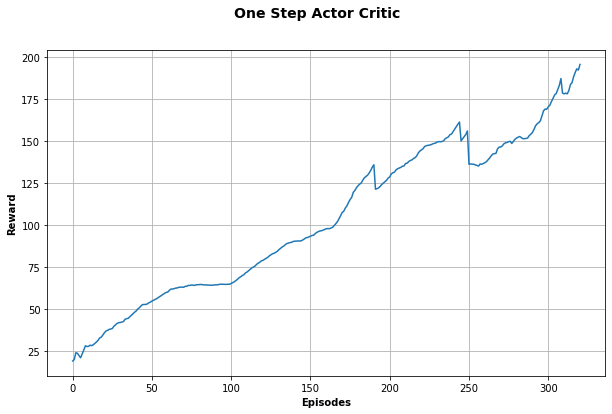

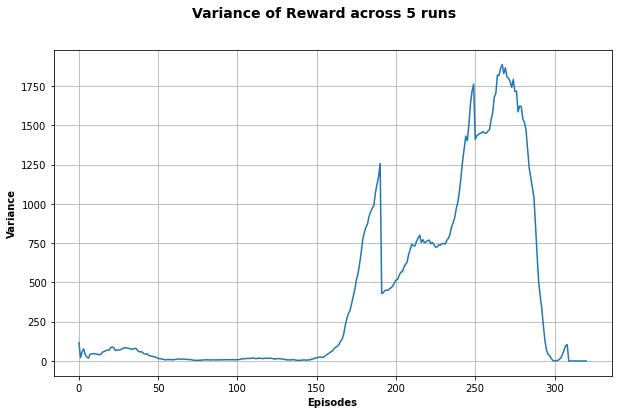

Number of episodes for each run: 209, 150, 145, 221 ,91


In [ ]:
### Plot of total reward vs episode
## Write Code Below
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()
print("Number of episodes for each run: 209, 150, 145, 221 ,91")

#### Full Returns

In [ ]:
env = gym.make('CartPole-v1')

#Initializing Agent
#Number of episodes
episodes = 500

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(5):
  average_reward_list=[]
  reward_list=[]
  agent = AgentFullReturn(lr=1e-4, action_size=env.action_space.n)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      state_trajectories = []
      actions = []
      reward_count = []
      iter = 0
      while not done and iter < 1000:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          state_trajectories.append(state)
          actions.append(action)
          reward_count.append(reward)
          #
          state = next_state ##Updating State
          iter+=1
      

      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      state_trajectories = tf.stack(state_trajectories)
      actions = tf.stack(actions)
      reward_count = tf.stack(reward_count)
      agent.learn(state_trajectories, actions, reward_count) ##Update Parameters

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > 195.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward 20.000000 Average Reward 20.600000
Episode  20 Reward 31.000000 Average Reward 27.300000
Episode  30 Reward 27.000000 Average Reward 26.000000
Episode  40 Reward 18.000000 Average Reward 25.700000
Episode  50 Reward 16.000000 Average Reward 22.000000
Episode  60 Reward 24.000000 Average Reward 25.200000
Episode  70 Reward 95.000000 Average Reward 30.700000
Episode  80 Reward 19.000000 Average Reward 22.500000
Episode  90 Reward 25.000000 Average Reward 28.000000
Episode  100 Reward 17.000000 Average Reward 18.400000
Episode  110 Reward 20.000000 Average Reward 16.400000
Episode  120 Reward 26.000000 Average Reward 28.800000
Episode  130 Reward 12.000000 Average Reward 19.900000
Episode  140 Reward 16.000000 Average Reward 20.400000
Episode  150 Reward 40.000000 Average Reward 24.000000
Episode  160 Reward 9.000000 Average Reward 26.600000
Episode  170 Reward 28.000000 Average Reward 26.800000
Episode  180 Reward 12.000000 Average Reward 16.500000
Episode  190 Reward 

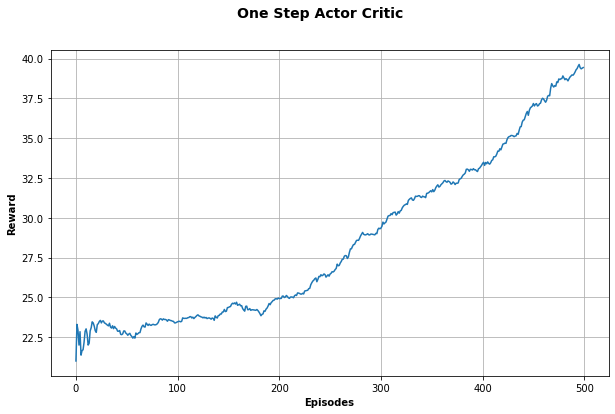

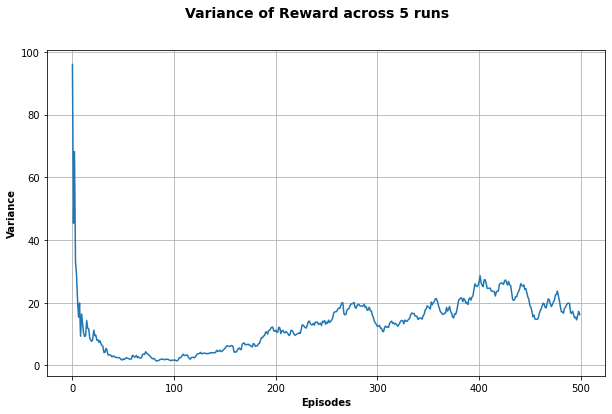

In [ ]:
### Plot of total reward vs episode
## Write Code Below
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()

#### n-step returns

In [ ]:
env = gym.make('CartPole-v1')

#Initializing Agent
#Number of episodes
episodes = 500

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(5):
  average_reward_list=[]
  reward_list=[]
  agent = AgentNStep(lr=1e-4, action_size=env.action_space.n)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      state_trajectories = []
      actions = []
      reward_count = []
      iter = 0
      while not done and iter < 1000:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          state_trajectories.append(state)
          actions.append(action)
          reward_count.append(reward)
          #
          state = next_state ##Updating State
          iter+=1
      

      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      state_trajectories = tf.stack(state_trajectories)
      actions = tf.stack(actions)
      reward_count = tf.stack(reward_count)
      agent.learn(state_trajectories, actions, reward_count) ##Update Parameters

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > 195.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward 59.000000 Average Reward 25.300000
Episode  20 Reward 54.000000 Average Reward 27.000000
Episode  30 Reward 10.000000 Average Reward 17.700000
Episode  40 Reward 27.000000 Average Reward 25.900000
Episode  50 Reward 40.000000 Average Reward 25.100000
Episode  60 Reward 42.000000 Average Reward 27.200000
Episode  70 Reward 23.000000 Average Reward 23.100000
Episode  80 Reward 25.000000 Average Reward 19.800000
Episode  90 Reward 8.000000 Average Reward 19.300000
Episode  100 Reward 15.000000 Average Reward 16.400000
Episode  110 Reward 10.000000 Average Reward 20.600000
Episode  120 Reward 16.000000 Average Reward 19.100000
Episode  130 Reward 28.000000 Average Reward 22.000000
Episode  140 Reward 19.000000 Average Reward 19.700000
Episode  150 Reward 12.000000 Average Reward 18.000000
Episode  160 Reward 28.000000 Average Reward 17.100000
Episode  170 Reward 39.000000 Average Reward 19.800000
Episode  180 Reward 32.000000 Average Reward 23.200000
Episode  190 Reward 

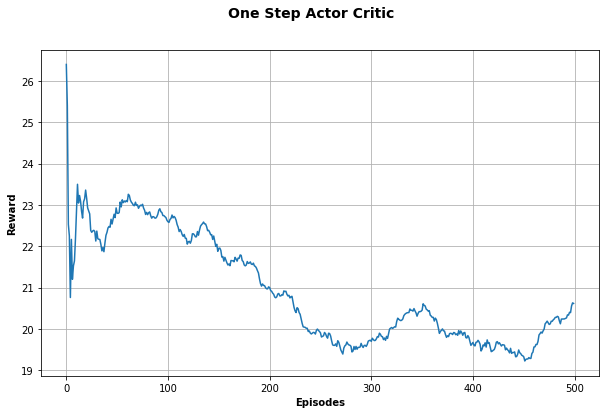

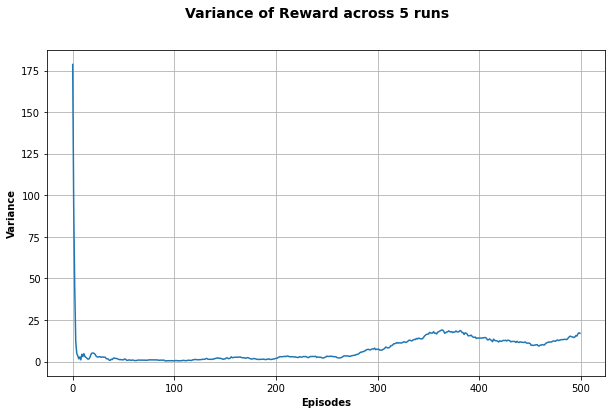

In [ ]:
### Plot of total reward vs episode
## Write Code Below
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()

## Acrobot-v1

#### One-step returns

In [ ]:
env = gym.make('Acrobot-v1')

#Initializing Agent
#Number of episodes
episodes = 600

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(5):
  average_reward_list=[]
  reward_list=[]
  agent = Agent(lr=0.00002, action_size=env.action_space.n, n_hidden1=256, n_hidden2=512)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      while not done:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          agent.learn(state, action, reward, next_state, done) ##Update Parameters
          state = next_state ##Updating State
      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > -90.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward -416.000000 Average Reward -472.400000
Episode  20 Reward -485.000000 Average Reward -399.900000
Episode  30 Reward -500.000000 Average Reward -421.700000
Episode  40 Reward -500.000000 Average Reward -440.400000
Episode  50 Reward -436.000000 Average Reward -451.700000
Episode  60 Reward -475.000000 Average Reward -426.100000
Episode  70 Reward -399.000000 Average Reward -417.700000
Episode  80 Reward -354.000000 Average Reward -429.800000
Episode  90 Reward -281.000000 Average Reward -324.600000
Episode  100 Reward -252.000000 Average Reward -283.000000
Episode  110 Reward -243.000000 Average Reward -232.400000
Episode  120 Reward -187.000000 Average Reward -197.100000
Episode  130 Reward -128.000000 Average Reward -149.000000
Episode  140 Reward -142.000000 Average Reward -160.800000
Episode  150 Reward -146.000000 Average Reward -153.400000
Episode  160 Reward -135.000000 Average Reward -150.500000
Episode  170 Reward -123.000000 Average Reward -152.300000
Episod

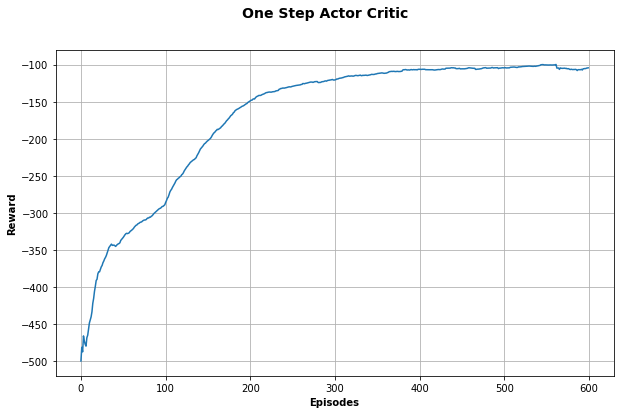

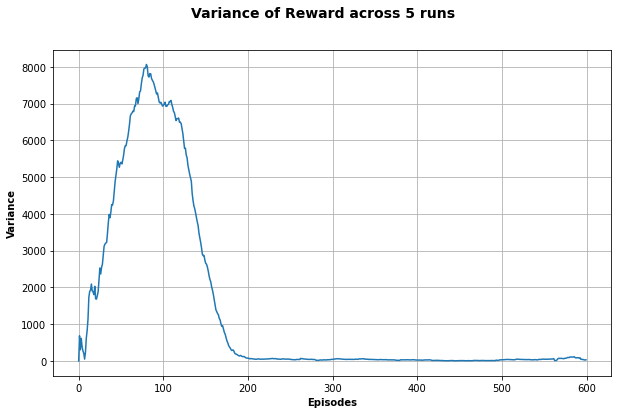

Number of episodes for each run: 600, 562, 600, 600 ,600


In [ ]:
### Plot of total reward vs episode
## Write Code Below
average_reward_list=tolerant_mean(average_reward_list_list[0:3])[0]
variance_reward_list=tolerant_mean(average_reward_list_list[0:3])[1]
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()
print("Number of episodes for each run: 600, 562, 600, 600 ,600")

#### Full Returns

In [ ]:
env = gym.make('Acrobot-v1')

#Initializing Agent
#Number of episodes
episodes = 100

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(4):
  average_reward_list=[]
  reward_list=[]
  agent = AgentFullReturn(lr=0.00002, action_size=env.action_space.n, n_hidden1=256, n_hidden2=512)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      state_trajectories = []
      actions = []
      reward_count = []
      iter = 0
      while not done and iter < 1000:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          state_trajectories.append(state)
          actions.append(action)
          reward_count.append(reward)
          #
          state = next_state ##Updating State
          iter+=1
      

      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      state_trajectories = tf.stack(state_trajectories)
      actions = tf.stack(actions)
      reward_count = tf.stack(reward_count)
      agent.learn(state_trajectories, actions, reward_count) ##Update Parameters

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > -90.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward -500.000000 Average Reward -487.100000
Episode  20 Reward -500.000000 Average Reward -500.000000
Episode  30 Reward -500.000000 Average Reward -500.000000
Episode  40 Reward -500.000000 Average Reward -500.000000
Episode  50 Reward -500.000000 Average Reward -492.600000
Episode  60 Reward -500.000000 Average Reward -500.000000
Episode  70 Reward -500.000000 Average Reward -490.200000
Episode  80 Reward -500.000000 Average Reward -500.000000
Episode  90 Reward -500.000000 Average Reward -500.000000
Episode  100 Reward -500.000000 Average Reward -478.100000
Episode  10 Reward -500.000000 Average Reward -500.000000
Episode  20 Reward -500.000000 Average Reward -500.000000
Episode  30 Reward -500.000000 Average Reward -500.000000
Episode  40 Reward -414.000000 Average Reward -491.400000
Episode  50 Reward -500.000000 Average Reward -500.000000
Episode  60 Reward -500.000000 Average Reward -500.000000
Episode  70 Reward -500.000000 Average Reward -495.800000
Episode  80 R

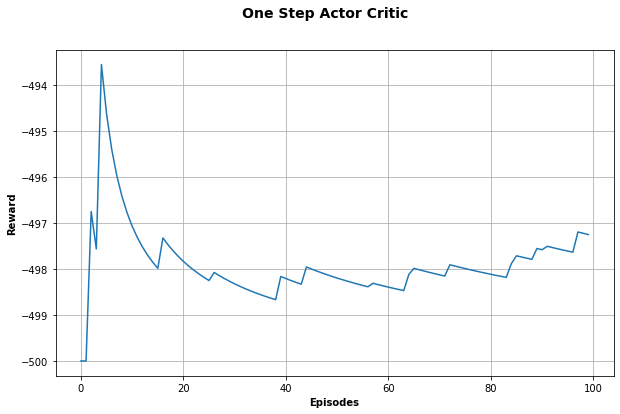

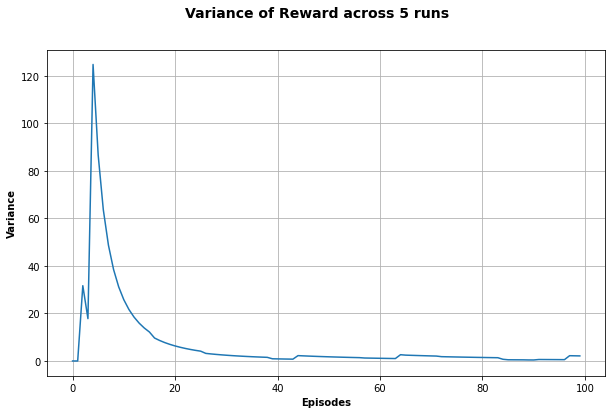

In [ ]:
### Plot of total reward vs episode
## Write Code Below
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()

#### n-step returns

In [ ]:
env = gym.make('Acrobot-v1')

#Initializing Agent
#Number of episodes
episodes = 100

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(4):
  average_reward_list=[]
  reward_list=[]
  agent = AgentNStep(lr=0.00002, action_size=env.action_space.n, n_hidden1=256, n_hidden2=512)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      state_trajectories = []
      actions = []
      reward_count = []
      iter = 0
      while not done and iter < 1000:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          state_trajectories.append(state)
          actions.append(action)
          reward_count.append(reward)
          #
          state = next_state ##Updating State
          iter+=1
      

      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      state_trajectories = tf.stack(state_trajectories)
      actions = tf.stack(actions)
      reward_count = tf.stack(reward_count)
      agent.learn(state_trajectories, actions, reward_count) ##Update Parameters

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > -90.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward -500.000000 Average Reward -500.000000
Episode  20 Reward -500.000000 Average Reward -500.000000
Episode  30 Reward -500.000000 Average Reward -500.000000
Episode  40 Reward -378.000000 Average Reward -487.800000
Episode  50 Reward -500.000000 Average Reward -500.000000
Episode  60 Reward -500.000000 Average Reward -500.000000
Episode  70 Reward -500.000000 Average Reward -500.000000
Episode  80 Reward -500.000000 Average Reward -500.000000
Episode  90 Reward -500.000000 Average Reward -500.000000
Episode  100 Reward -500.000000 Average Reward -500.000000
Episode  10 Reward -500.000000 Average Reward -488.000000
Episode  20 Reward -451.000000 Average Reward -495.100000
Episode  30 Reward -500.000000 Average Reward -500.000000
Episode  40 Reward -500.000000 Average Reward -480.600000
Episode  50 Reward -500.000000 Average Reward -490.700000
Episode  60 Reward -500.000000 Average Reward -500.000000
Episode  70 Reward -442.000000 Average Reward -487.200000
Episode  80 R

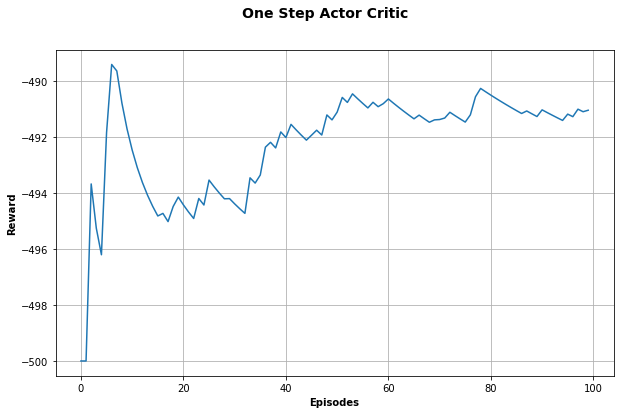

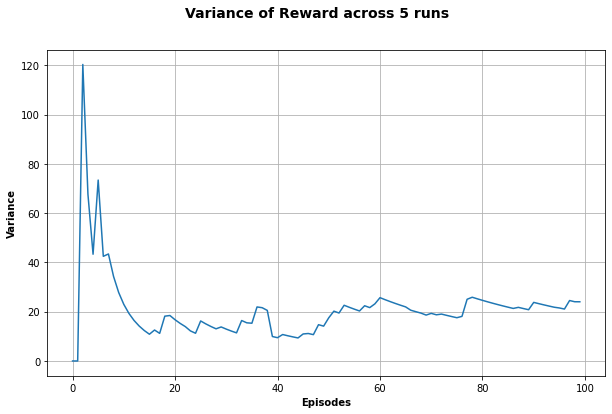

In [ ]:
### Plot of total reward vs episode
## Write Code Below
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()

## Mountaincar-v0

#### One-step return

In [ ]:
env = gym.make('MountainCar-v0')

#Initializing Agent
#Number of episodes
episodes = 100

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(4):
  average_reward_list=[]
  reward_list=[]
  agent = Agent(lr=0.00001, action_size=env.action_space.n, n_hidden1=512, n_hidden2=512)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      while not done:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          agent.learn(state, action, reward, next_state, done) ##Update Parameters
          state = next_state ##Updating State
      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > -90.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward -200.000000 Average Reward -200.000000
Episode  20 Reward -200.000000 Average Reward -200.000000
Episode  30 Reward -200.000000 Average Reward -200.000000
Episode  40 Reward -200.000000 Average Reward -200.000000
Episode  50 Reward -200.000000 Average Reward -200.000000
Episode  60 Reward -200.000000 Average Reward -200.000000
Episode  70 Reward -200.000000 Average Reward -200.000000
Episode  80 Reward -200.000000 Average Reward -200.000000
Episode  90 Reward -200.000000 Average Reward -200.000000
Episode  100 Reward -200.000000 Average Reward -200.000000
Episode  10 Reward -200.000000 Average Reward -200.000000
Episode  20 Reward -200.000000 Average Reward -200.000000
Episode  30 Reward -200.000000 Average Reward -200.000000
Episode  40 Reward -200.000000 Average Reward -200.000000
Episode  50 Reward -200.000000 Average Reward -200.000000
Episode  60 Reward -200.000000 Average Reward -200.000000
Episode  70 Reward -200.000000 Average Reward -200.000000
Episode  80 R

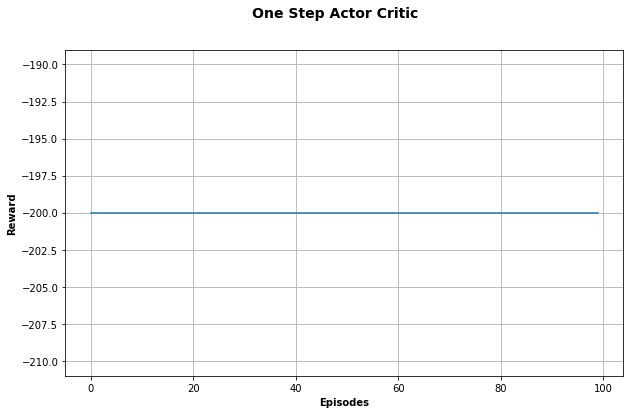

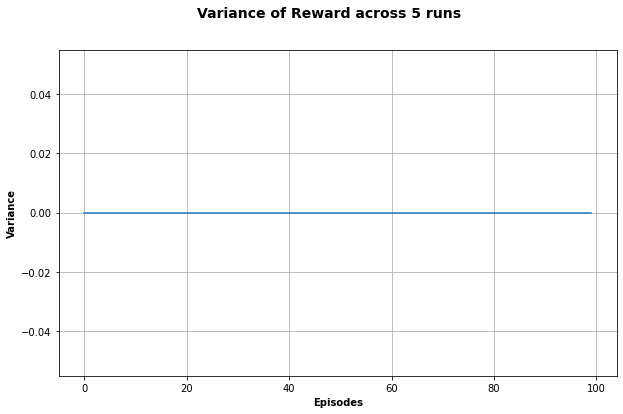

In [ ]:
### Plot of total reward vs episode
## Write Code Below
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()

#### Full Returns

In [ ]:
env = gym.make('MountainCar-v0')

#Initializing Agent
#Number of episodes
episodes = 100

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(4):
  average_reward_list=[]
  reward_list=[]
  agent = AgentFullReturn(lr=0.00001, action_size=env.action_space.n, n_hidden1=512, n_hidden2=512)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      state_trajectories = []
      actions = []
      reward_count = []
      iter = 0
      while not done and iter < 1000:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          state_trajectories.append(state)
          actions.append(action)
          reward_count.append(reward)
          #
          state = next_state ##Updating State
          iter+=1
      

      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      state_trajectories = tf.stack(state_trajectories)
      actions = tf.stack(actions)
      reward_count = tf.stack(reward_count)
      agent.learn(state_trajectories, actions, reward_count) ##Update Parameters

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > -90.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward -200.000000 Average Reward -200.000000
Episode  20 Reward -200.000000 Average Reward -200.000000
Episode  30 Reward -200.000000 Average Reward -200.000000
Episode  40 Reward -200.000000 Average Reward -200.000000
Episode  50 Reward -200.000000 Average Reward -200.000000
Episode  60 Reward -200.000000 Average Reward -200.000000
Episode  70 Reward -200.000000 Average Reward -200.000000
Episode  80 Reward -200.000000 Average Reward -200.000000
Episode  90 Reward -200.000000 Average Reward -200.000000
Episode  100 Reward -200.000000 Average Reward -200.000000
Episode  10 Reward -200.000000 Average Reward -200.000000
Episode  20 Reward -200.000000 Average Reward -200.000000
Episode  30 Reward -200.000000 Average Reward -200.000000
Episode  40 Reward -200.000000 Average Reward -200.000000
Episode  50 Reward -200.000000 Average Reward -200.000000
Episode  60 Reward -200.000000 Average Reward -200.000000
Episode  70 Reward -200.000000 Average Reward -200.000000
Episode  80 R

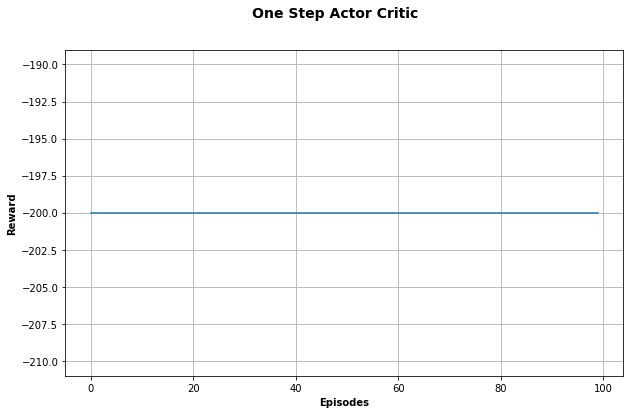

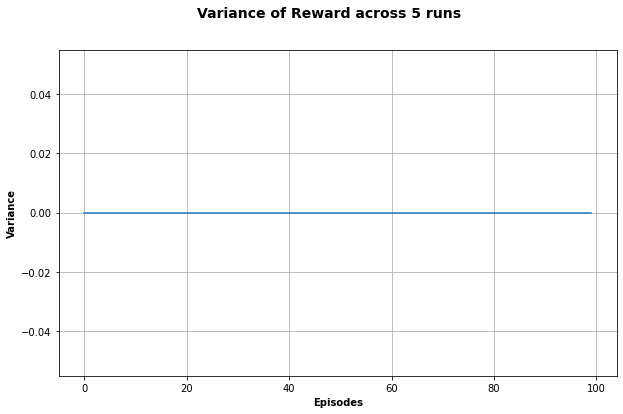

In [ ]:
### Plot of total reward vs episode
## Write Code Below
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()

#### n-step returns

In [ ]:
env = gym.make('MountainCar-v0')

#Initializing Agent
#Number of episodes
episodes = 100

average_reward_list_list=[]
total_reward_list=[]
begin_time = datetime.datetime.now()

for i in range(4):
  average_reward_list=[]
  reward_list=[]
  agent = AgentNStep(lr=0.00001, action_size=env.action_space.n, n_hidden1=512, n_hidden2=512)
  tf.compat.v1.reset_default_graph()
  for ep in range(1, episodes + 1):
      state = env.reset().reshape(1,-1)
      done = False
      ep_rew = 0
      state_trajectories = []
      actions = []
      reward_count = []
      iter = 0
      while not done and iter < 1000:
          action = agent.sample_action(state) ##Sample Action
          next_state, reward, done, info = env.step(action) ##Take action
          next_state = next_state.reshape(1,-1)
          ep_rew += reward  ##Updating episode reward
          state_trajectories.append(state)
          actions.append(action)
          reward_count.append(reward)
          #
          state = next_state ##Updating State
          iter+=1
      

      reward_list.append(ep_rew)
      average_reward_list.append(np.mean(reward_list[-100:]))

      state_trajectories = tf.stack(state_trajectories)
      actions = tf.stack(actions)
      reward_count = tf.stack(reward_count)
      agent.learn(state_trajectories, actions, reward_count) ##Update Parameters

      if ep % 10 == 0:
          avg_rew = np.mean(reward_list[-10:])
          print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

      if ep>100 and ep % 100:
          avg_100 =  np.mean(reward_list[-100:])
          if avg_100 > -90.0:
              print('Stopped at Episode ',ep-100)
              break
  total_reward_list.append(np.sum(reward_list))
  average_reward_list_list.append(average_reward_list)
average_reward_list=tolerant_mean(average_reward_list_list)[0]
variance_reward_list=tolerant_mean(average_reward_list_list)[1]
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode  10 Reward -200.000000 Average Reward -200.000000
Episode  20 Reward -200.000000 Average Reward -200.000000
Episode  30 Reward -200.000000 Average Reward -200.000000
Episode  40 Reward -200.000000 Average Reward -200.000000
Episode  50 Reward -200.000000 Average Reward -200.000000
Episode  60 Reward -200.000000 Average Reward -200.000000
Episode  70 Reward -200.000000 Average Reward -200.000000
Episode  80 Reward -200.000000 Average Reward -200.000000
Episode  90 Reward -200.000000 Average Reward -200.000000
Episode  100 Reward -200.000000 Average Reward -200.000000
Episode  10 Reward -200.000000 Average Reward -200.000000
Episode  20 Reward -200.000000 Average Reward -200.000000
Episode  30 Reward -200.000000 Average Reward -200.000000
Episode  40 Reward -200.000000 Average Reward -200.000000
Episode  50 Reward -200.000000 Average Reward -200.000000
Episode  60 Reward -200.000000 Average Reward -200.000000
Episode  70 Reward -200.000000 Average Reward -200.000000
Episode  80 R

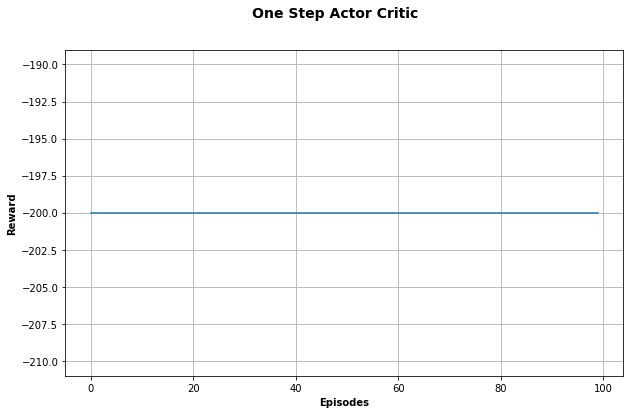

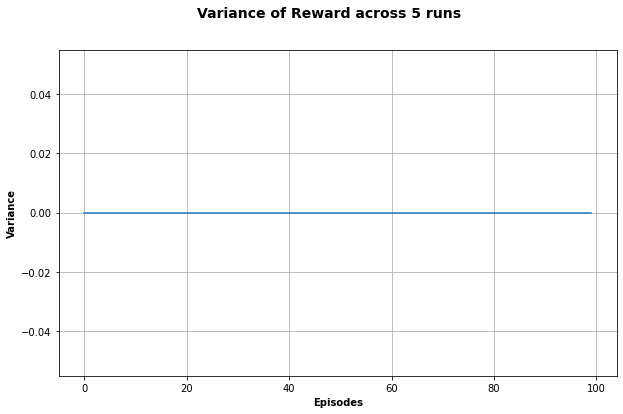

In [ ]:
### Plot of total reward vs episode
## Write Code Below
plt.figure(figsize=(10,6))
plt.plot(average_reward_list)
plt.suptitle("One Step Actor Critic", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Reward", fontweight = 'bold')
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(variance_reward_list)
plt.suptitle("Variance of Reward across 5 runs", fontweight = 'bold', fontsize = 14)
plt.xlabel("Episodes", fontweight = 'bold')
plt.ylabel("Variance", fontweight = 'bold')
plt.grid(True)
plt.show()